In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from sklearn.model_selection import GridSearchCV


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Step - 2 (Download the dataset)

In [2]:
import tensorflow as tf 
cifar10 = tf.keras.datasets.cifar10

### Step - 3 (Load the Dataset)

In [3]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


170508288/170498071 [==============================] - 3s 0us/step
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


#### Step - 4 (Visualization)


Next we visualize the CIFAR-10 dataset. Although these functions are being written for you, we highly recommend you go through the code and make yourself familiar as these are things you will be required to do very often when working on AI/ML projects

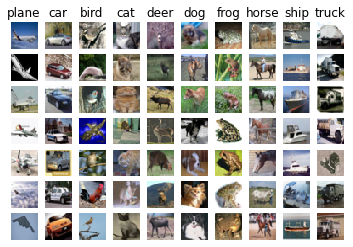

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Step - 5 (Flattening the images)

In the next cell we flatten each image into a single dimensional vector so that it is easy to process. You should be able to reason about the dimensions comfortable.

In [5]:
# Subsample the data for more efficient code execution in this exercise
try:
    del X_train, y_train, X_val
    del X_test, y_test,y_val
    print('Clear previously loaded data.')
except:
    pass
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_training=15000
val=1000
mask = range(num_training, num_training + val)
X_val = X_train[mask]
y_val = y_train[(mask)]
y_val = np.ravel(y_val)

mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
y_train = np.ravel(y_train)

num_test = 5000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
y_test = np.ravel(y_test)


# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

print('X_train and X_test shapes: ',X_train.shape, X_test.shape)
print('y_train and y_test shapes: ',y_train.shape, y_test.shape)
print('X_val and y_val shapes: ' ,X_val.shape, y_val.shape)

X_train and X_test shapes:  (15000, 3072) (5000, 3072)
y_train and y_test shapes:  (15000,) (5000,)
X_val and y_val shapes:  (1000, 3072) (1000,)


### **The intuition behind KNN algorithm**
The K-NN working can be explained on the basis of the below algorithm:

**Step-1**: Select the number K nearest neighborhood.

**Step-2**: Calculate the Euclidean distance of K number of neighbors to the given datapoint.

**Step-3**: Take the K nearest neighbors as per the calculated Euclidean distance to the given point.

**Step-4**: Among these k neighbors, count the number of the data points in each category.

**Step-5**: Assign the new data points to that category for which the number of the neighbor is maximum.

**Pros**

* It is simple to implement.

* It is robust to the noisy training data.

**cons**

* The computation cost is expensive, because of calculating the distance between the data points for all the training samples.
* It is lazy algorithm as it doesnt learn from the training data and instead it stores the dataset.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
import time
k = int(input("Enter the value of k for k-Nearest Neighbor Classifier: "))
print("Computation under process")
print("Please Wait...")
knn = KNeighborsClassifier(n_neighbors=k)   ##### importing k from the user

tic = time.time()
knn.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_predict= knn.predict(X_val)
completed=time.time()
duration2=completed-start
print('validation duration is:',duration2)

print("Prediction complete")
print(classification_report(y_val, y_val_predict))

Enter the value of k for k-Nearest Neighbor Classifier: 3
Computation under process
Please Wait...
Training duration is:  0.002264738082885742
validation duration is: 2.912498950958252
Prediction complete
              precision    recall  f1-score   support

           0       0.26      0.55      0.36        89
           1       0.36      0.12      0.18       103
           2       0.20      0.51      0.29       106
           3       0.22      0.18      0.19       108
           4       0.21      0.36      0.26       103
           5       0.53      0.17      0.26        93
           6       0.25      0.17      0.20       111
           7       0.59      0.10      0.17       102
           8       0.37      0.45      0.40        91
           9       0.40      0.06      0.11        94

    accuracy                           0.26      1000
   macro avg       0.34      0.27      0.24      1000
weighted avg       0.34      0.26      0.24      1000



### **Classification Report**
**Precision** is defined as the ratio of true positives to the sum of true and false positives.

**Recall** is defined as the ratio of true positives to the sum of true positives and false negatives.

**F1_score** is the weighted harmonic mean of precision and recall.

**Support** is the number of actual occurrences of the class in the dataset.




<!-- ![Alt Text](image path "title") -->
![Alt Text](https://miro.medium.com/max/1068/1*EXa-_699fntpUoRjZeqAFQ.jpeg "Optional Title")

The **classification report** is like a progress report for the student. Where the progress report depicts the marks of the student which he had gone in numerous of exams. Likewise, the classification report performs numerous tests on the model and displays the output which usually saves the time and increases the readabilty.

From the classification report, it can be seen that the model has an average performance ranging from 15 to 50 for precision, recall, f1-score. Accuracy shows in value of 26%.

In [7]:
tic=time.time()
best_leaf = list(range(1,10))
best_neighbors = list(range(1,10))
p=[1,2]
#Convert to dictionary
parameter_tuning = dict(leaf_size=best_leaf, n_neighbors=best_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
knn_tuning = GridSearchCV(knn_2, parameter_tuning, cv=10)
#Fit the model
best_model = knn_tuning.fit(X_val,y_val)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
toc=time.time()
print(toc-tic)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 7
223.40604615211487


The classification report is like a progress report for the student. Where the progress report depicts the marks of the student which he had gone in numerous of exams. Likewise, the classification report performs numerous tests on the model and displays the output which usually saves the time and increases the readabilty.

From the classification report, it can be seen that the model has an average performance ranging from 15 to 50 for precision, recall, f1-score. Accuracy  shows in value of 26%.


In [8]:
#After the above results we come to know that that the best_leaf=1, best p is 1 and best n_neighbors is 7

from sklearn.neighbors import KNeighborsClassifier
import time
# so taking the above vaules into consideration we tune the knn model

print("Computation under process")
print("Please Wait...")
knn = KNeighborsClassifier(n_neighbors=7,leaf_size=1,p=1)   

tic = time.time()
knn.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_predict= knn.predict(X_val)
completed=time.time()
duration2=completed-start
print('validation duration is:',duration2)

print("Prediction complete")
print(classification_report(y_val, y_val_predict))


Computation under process
Please Wait...
Training duration is:  0.0016605854034423828
validation duration is: 46.05100965499878
Prediction complete
              precision    recall  f1-score   support

           0       0.35      0.58      0.44        89
           1       0.64      0.14      0.22       103
           2       0.23      0.51      0.32       106
           3       0.23      0.14      0.17       108
           4       0.20      0.40      0.27       103
           5       0.46      0.19      0.27        93
           6       0.26      0.23      0.24       111
           7       0.52      0.17      0.25       102
           8       0.41      0.60      0.49        91
           9       0.64      0.19      0.30        94

    accuracy                           0.31      1000
   macro avg       0.39      0.31      0.30      1000
weighted avg       0.39      0.31      0.29      1000



#### we can clearly see the increase of accuracy from **26%** to **31%** after the hyper parameter tuning during validation this is the probable best tuning so we gonna move to testing the untouched dataset.

In [46]:
## testing the model with test dataset
st=time.time()
y_test_predict= knn.predict(X_test)
com=time.time()
print('Testing Duration is: ', com-st)
print(classification_report(y_test,y_test_predict))

Testing Duration is:  245.58119010925293
              precision    recall  f1-score   support

           0       0.33      0.56      0.41       488
           1       0.62      0.23      0.33       505
           2       0.22      0.46      0.29       512
           3       0.32      0.20      0.24       497
           4       0.23      0.42      0.30       507
           5       0.40      0.18      0.24       488
           6       0.30      0.27      0.28       491
           7       0.63      0.20      0.30       495
           8       0.45      0.64      0.53       504
           9       0.72      0.18      0.28       513

    accuracy                           0.33      5000
   macro avg       0.42      0.33      0.32      5000
weighted avg       0.42      0.33      0.32      5000



In [47]:
from sklearn.metrics import accuracy_score
print( "The accuracy of the knn model is: ",accuracy_score(y_test,y_test_predict))
print("the f1_score of knn model is:",f1_score( y_test,y_test_predict, average='macro'))

The accuracy of the knn model is:  0.333
the f1_score of knn model is: 0.322590380050532


### **Intution behind SVM algorithm**

**SVM** algorithm helps to find the best line or decision boundary; this best boundary or region is called as a hyperplane.The distance between the vectors and the hyperplane is called as margin. And the goal of SVM is to maximize this margin.

**Hyperplane** It is use to find out the best decision boundary that helps to classify the data points.

**suport vectors** the data points that are the closest to the hyperplane and which affect the position of the hyperplane are termed as Support Vector.

**Pros**

It works really well with a clear margin of separation.

It is effective in high dimensional spaces.

**Cons**

It doesn’t perform well when we have large data set because the required training time is higher.

It also doesn’t perform very well, when the data set has more noise

In [9]:
from sklearn.svm import SVC
import time

clf = SVC()  

tic = time.time()
clf.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_predict= clf.predict(X_val)
completed=time.time()
duration2=completed-start
print('validation duration is:',duration2)

print("Prediction complete")
print(classification_report(y_val, y_val_predict))

Training duration is:  447.83129596710205
validation duration is: 43.382887840270996
Prediction complete
              precision    recall  f1-score   support

           0       0.56      0.51      0.53        89
           1       0.58      0.52      0.55       103
           2       0.34      0.39      0.36       106
           3       0.33      0.33      0.33       108
           4       0.38      0.36      0.37       103
           5       0.36      0.33      0.34        93
           6       0.39      0.41      0.40       111
           7       0.51      0.40      0.45       102
           8       0.59      0.60      0.60        91
           9       0.48      0.62      0.54        94

    accuracy                           0.44      1000
   macro avg       0.45      0.45      0.45      1000
weighted avg       0.45      0.44      0.44      1000



In [15]:
tic=time.time()
## creating a dictionary for parameter tuning
parameter_tuning = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}         
svc_2 = SVC()
#Use GridSearch
svc_tuning = GridSearchCV(svc_2, parameter_tuning)
#Fit the model
best_model = svc_tuning.fit(X_val,y_val)
#Print The value of best Hyperparameters
print('Best c(Regularization) value:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])
toc=time.time()
print(toc-tic)

Best c(Regularization) value: 0.1
Best gamma: 1
Best kernel: poly
362.64636158943176


### After the above results of parameter tuning we get to know that c with 0.1 and gamma with 1 and kernel of poly gives the best results.

In [16]:
from sklearn.svm import SVC
import time

clf = SVC(C=0.1,gamma=1,kernel='poly')  

tic = time.time()
clf.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_predict= clf.predict(X_val)
completed=time.time()
duration2=completed-start
print('validation duration is:',duration2)

print("Prediction complete")
print(classification_report(y_val, y_val_predict))

Training duration is:  523.6094818115234
validation duration is: 26.973674297332764
Prediction complete
              precision    recall  f1-score   support

           0       0.48      0.53      0.50        89
           1       0.54      0.47      0.50       103
           2       0.24      0.29      0.26       106
           3       0.35      0.34      0.35       108
           4       0.39      0.46      0.42       103
           5       0.29      0.32      0.31        93
           6       0.44      0.32      0.37       111
           7       0.52      0.49      0.50       102
           8       0.55      0.55      0.55        91
           9       0.57      0.53      0.55        94

    accuracy                           0.42      1000
   macro avg       0.44      0.43      0.43      1000
weighted avg       0.43      0.42      0.43      1000



In [ ]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()


we can clearly see the increase of f1_score near to 50% after the hyper parameter tuning during validation this is the probable best tuning so we gonna move to testing the untouched dataset.

In [19]:
## testing the model with test dataset
st=time.time()
y_test_predicted= clf.predict(X_test)
com=time.time()
print('Testing Duration is: ', com-st)
print(classification_report(y_test,y_test_predicted))

Testing Duration is:  131.88028049468994
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       488
           1       0.55      0.57      0.56       505
           2       0.32      0.38      0.35       512
           3       0.28      0.30      0.29       497
           4       0.39      0.39      0.39       507
           5       0.35      0.33      0.34       488
           6       0.46      0.41      0.43       491
           7       0.54      0.51      0.52       495
           8       0.60      0.62      0.61       504
           9       0.55      0.46      0.50       513

    accuracy                           0.45      5000
   macro avg       0.45      0.45      0.45      5000
weighted avg       0.45      0.45      0.45      5000



In [44]:
from sklearn.metrics import accuracy_score
print( "The accuracy of the svm model is: ",accuracy_score(y_test,y_test_predicted))
print("f1_score of svm model is:",f1_score(y_test_predicted, y_test, average='macro'))

The accuracy of the svm model is:  0.4482
f1_score of svm model is: 0.4489225270704099


## **Intuition behind naive bayes**

**Bayes' theorem** is also known as Bayes' Rule or Bayes' law, which is used to determine the probability of a hypothesis with prior knowledge. It depends on the conditional probability.


<!-- ![Alt Text](image path "title") -->
![Alt Text](https://static.javatpoint.com/tutorial/machine-learning/images/naive-bayes-classifier-algorithm.png "Optional Title")

Where,

**P(A|B) is Posterior probability**: Probability of hypothesis A on the observed event B.

**P(B|A) is Likelihood probability**: Probability of the evidence given that the probability of a hypothesis is true.

**P(A) is Prior Probability**: Probability of hypothesis before observing the evidence.

**P(B) is Marginal Probability**: Probability of Evidence.



**Pros**

* It performs well in Multi-class predictions as compared to the other Algorithms.
* It is the most popular choice for text classification problems.

**Cons**
* Naive Bayes assumes that all features are independent or unrelated, so it cannot learn the relationship between features.


In [22]:
from sklearn.naive_bayes import GaussianNB
import time

naive_bayes_clf=GaussianNB()

tic = time.time()
naive_bayes_clf.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_pre= naive_bayes_clf.predict(X_val)
completed=time.time()
duration2=completed-start
print('validation duration is:',duration2)

print("Prediction complete")
print(classification_report(y_val, y_val_pre))

Training duration is:  0.4291536808013916
validation duration is: 0.14630770683288574
Prediction complete
              precision    recall  f1-score   support

           0       0.29      0.51      0.37        89
           1       0.40      0.17      0.23       103
           2       0.19      0.07      0.10       106
           3       0.24      0.06      0.10       108
           4       0.23      0.38      0.28       103
           5       0.33      0.32      0.33        93
           6       0.20      0.40      0.26       111
           7       0.31      0.10      0.15       102
           8       0.41      0.46      0.44        91
           9       0.36      0.45      0.40        94

    accuracy                           0.28      1000
   macro avg       0.30      0.29      0.27      1000
weighted avg       0.29      0.28      0.26      1000



In [28]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=naive_bayes_clf, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')


In [32]:
tic=time.time()       
NB_2 = GaussianNB()
#Use GridSearch
NB_tuning = GridSearchCV(NB_2, params_NB)
#Fit the model
best_model = NB_tuning.fit(X_val,y_val)
#Print The value of best Hyperparameters
print('Best var_smoothing value:', best_model.best_estimator_.get_params()['var_smoothing'])
toc=time.time()
print(toc-tic)

Best var_smoothing value: 0.04328761281083057
27.360945224761963


In [37]:
import pandas as pd
results_NB = pd.DataFrame(NB_tuning.cv_results_['params'])
results_NB['test_score'] = NB_tuning.cv_results_['mean_test_score']

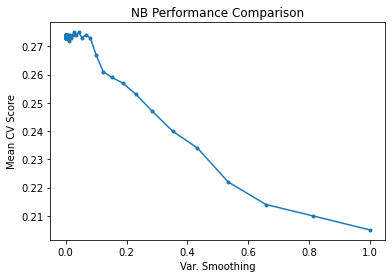

In [38]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [40]:
#testing the model with untouched data
NB_2 = GaussianNB(var_smoothing=0.04328761281083057)
NB_2.fit(X_train,y_train)
st=time.time()
y_test_predicte= NB_2.predict(X_test)
com=time.time()
print('Testing Duration is: ', com-st)
print(classification_report(y_test,y_test_predicte))

Testing Duration is:  0.7604286670684814
              precision    recall  f1-score   support

           0       0.27      0.47      0.34       488
           1       0.41      0.13      0.20       505
           2       0.17      0.07      0.10       512
           3       0.25      0.04      0.07       497
           4       0.22      0.41      0.29       507
           5       0.30      0.24      0.27       488
           6       0.24      0.50      0.33       491
           7       0.37      0.12      0.18       495
           8       0.39      0.52      0.44       504
           9       0.41      0.42      0.41       513

    accuracy                           0.29      5000
   macro avg       0.30      0.29      0.26      5000
weighted avg       0.30      0.29      0.26      5000



In [42]:
from sklearn.metrics import f1_score
f1_score(y_test_predicte, y_test, average='macro')

0.26272293068852826

##The algorithms performance details tabulated below:

Algorithm | Accuracy | F1_score
:-|:-:|-:
**KNN**|*33*|32 
**SVM**|*44*| 44
**NB**|*29*| 26